In [107]:
import openai
import time
import re
import requests
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from dotenv import load_dotenv
from sklearn.metrics import accuracy_score, f1_score, classification_report

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [23]:
# load API key and endpoint info from Azure AI
load_dotenv()
openai.api_type = "azure"
openai.api_version = "2023-05-15" 
openai.api_base = os.getenv("ENDPOINT")  
openai.api_key = os.getenv("KEY1")

In [89]:
df = pd.read_csv('../../data/phmrc/phmrc_adult_tokenized.csv')

In [26]:
def get_embedding(label: str) -> float:
    label = label.lower()
    if label not in label_to_score:
        print(label)
        return 0
    return label_to_score[label]

In [27]:
label_to_score = {
    'aids-tb': 0,
    'communicable': 1,
    'external': 2,
    'maternal': 3, 
    'non-communicable': 4
}

score_to_label = {
    0: 'aids-tb',
    1: 'communicable',
    2: 'external',
    3: 'maternal',
    4: 'non-communicable' 
}

# get score for each label

df['gs_cod_score'] = [get_embedding(x) for x in df['gs_cod']]

# Create dictionary for each COD score and its proportion
cod_proportions = df['gs_cod_score'].value_counts(normalize=True).to_dict()
cod_proportions

{4: 0.55981073488097,
 2: 0.146976193996747,
 1: 0.13425994381191778,
 0: 0.09670264675439894,
 3: 0.062250480555966284}

In [45]:
prompt_template = """
<narrative>
INPUT
</narrative>

<labels>
aids-tb: Patient died resulting from HIV-AIDs or Tuberculosis.
communicable: Patient died from a communicable disease such as pneumonia, diarrhea 
or dysentery.
external: Patient died from external causes such as fires,
drowning, road traffic, falls, poisonous animals, suicide, 
homicide, or other injuries.
maternal: Patient died from pregnancy or childbirth 
including from severe bleeding, sepsis, pre-eclampsia and eclampsia.
non-communicable: Patient died from a non-communicable disease such as cirrhosis,
epilepsy, acute myocardial infarction, copd, renal failure, cancer, diabetes,
stroke, malaria, asthma.
</labels>

<options>
aids-tb, 
communicable, 
external, 
maternal, 
non-communicable
</options>


Which label from options best applies applies to the narrative? 
If you are not sure, return your best guess. 
Limit your response to one of the options exactly as it appears in the list.
"""

# remove \n
prompt_template = prompt_template.replace('\n', '')

In [29]:
def inspect_narrative(row):
    print('Narrative: ' + df['narrative'][row])
    print('True Label: ' + df['gs_text34'][row])
    print('Broad Category: ' + df['gs_cod'][row])
    print('Embedding Representation: ' + str(label_to_score[df['gs_cod'][row]]))

In [30]:
inspect_narrative(21)

Narrative: the client thanked for service which provided in the hospital_x000d__x000d_
the client transfer death certificate to their original home [place]
True Label: other cardiovascular diseases
Broad Category: non-communicable
Embedding Representation: 4


# Test it on a single example

In [117]:
# # try by inputting a specific text narrative
# text = df['narrative'][100]

# # call model
# response = None
# while response is None:
#     try:
#         response = openai.ChatCompletion.create(
#         engine="gpt-4-32k", # deployment name on openAI Azure
#         messages=[
#                 {"role": "user", "content": prompt_template.replace("INPUT", text)}
#             ],
#         temperature=0
#         )
#     except Exception as e:
#         print(e)
#         time.sleep(1)
        
# score = get_embedding(response["choices"][0]["message"]["content"])
# print(response["choices"][0]["message"]["content"])
# print(score)

non-communicable
4


# Zero Shot Prediction on all data.

In [35]:
# # run all narratives

# zeroshot_predictions = []

# for narrative in tqdm(df['narrative']):
#     # call model
#     response = None
#     while response is None:
#         try:
#             response = openai.ChatCompletion.create(
#             engine="gpt-4-32k", # deployment name on openAI Azure
#             messages=[
#                     {"role": "user", "content": prompt_template.replace("INPUT", narrative)}
#                 ],
#             temperature=0
#             )
#         except Exception as e:
#             print(e)
#             time.sleep(1)

#     score = response["choices"][0]["message"]["content"]
#     zeroshot_predictions.append(score)

 16%|█████▉                               | 1078/6763 [23:35<2:13:58,  1.41s/it]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 17%|█████▊                             | 1124/6763 [1:56:43<2:39:30,  1.70s/it]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 20%|███████                            | 1358/6763 [2:12:37<1:29:20,  1.01it/s]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 21%|███████▎                           | 1408/6763 [2:24:08<2:51:43,  1.92s/it]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 23%|████████▏                          | 1584/6763 [3:06:58<1:38:27,  1.14s/it]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 26%|█████████                          | 1758/6763 [3:20:38<1:49:10,  1.31s/it]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 27%|█████████▍                         | 1829/6763 [3:32:25<1:54:27,  1.39s/it]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 61%|██████████████████████▍              | 4099/6763 [4:30:10<40:47,  1.09it/s]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 82%|██████████████████████████████▍      | 5553/6763 [5:12:50<15:44,  1.28it/s]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 84%|███████████████████████████████▏     | 5706/6763 [5:25:32<17:28,  1.01it/s]

Error communicating with OpenAI: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


100%|█████████████████████████████████████| 6763/6763 [5:48:19<00:00,  3.09s/it]


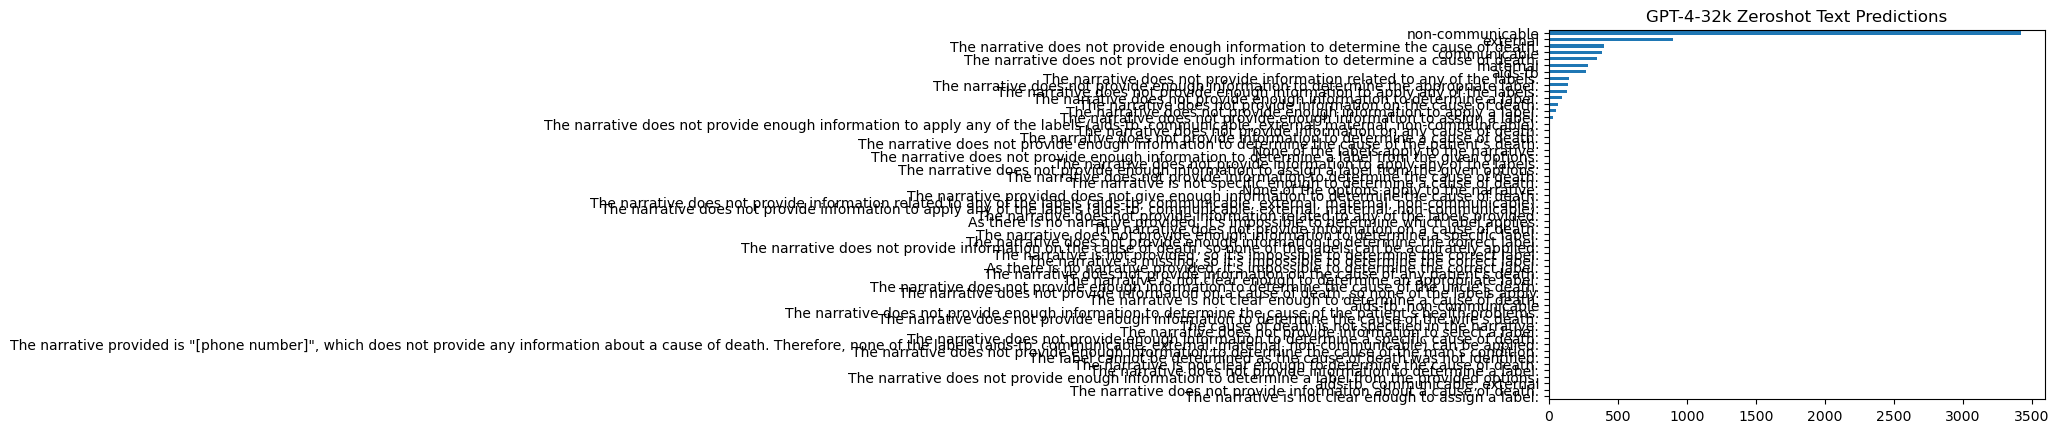

In [36]:
pd.Series(zeroshot_predictions).value_counts().plot.barh(title='GPT-4-32k Zeroshot Text Predictions').invert_yaxis()

In [37]:
# get embeddings for text predictions. If prediction not in list, use 'non-communicable'
cod_list = ['aids-tb', 'communicable', 'external', 'maternal', 'non-communicable']
zeroshot_scores = [get_embedding(x) if x in cod_list else get_embedding('non-communicable') for x in zeroshot_predictions]

In [38]:
# write out to csv
pd.Series(zeroshot_predictions).to_csv("gpt4-32k_zeroshot_text.csv", index=False)
pd.Series(zeroshot_scores).to_csv("gpt4-32k_zeroshot_score.csv", index=False)

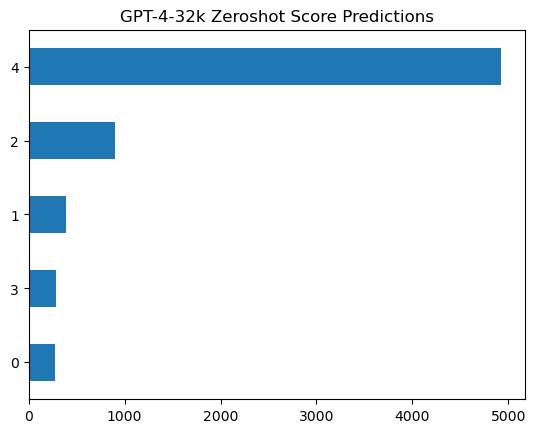

In [40]:
# plot scores distribution
pd.Series(zeroshot_scores).value_counts().plot.barh(title='GPT-4-32k Zeroshot Score Predictions').invert_yaxis()

## Few Shot Prediction on all data

In [31]:
# Define a function to perform the random sampling within each group
n=1
def random_sample(group):
    return group.sample(n, random_state = 2)

In [32]:
# function to take in dataframe and output fewshot prompting examples in JSON format
def make_fewshot_examples(input_df, obs, leave_out = ''):
    '''
    input_df :: pandas dataframe
    obs :: integer value number of observations for each site/COD permutation
    leave_out :: string for which site to leave out of the data frame for sampling
    This function takes a random subset of size obs from df subset for each site and COD category
    creates a user/assistant prompt example from the 'gs_cod' and 'narrative' columns
    returns all few shot examples as a list of dictionaries
    leave_out defaults to not excluding any sites
    '''
    
    # set n for random_sample function
    n = obs
    
    # subset inpute df to to all 5/6 sites other than leave_out
    exclude_df = input_df[input_df['site'] != leave_out]
    
    # Apply the sample function to each group defined by 'site' and 'gs_cod'
    subset_df = exclude_df.groupby(['site', 'gs_cod'], group_keys=False).apply(random_sample)
    
    # Reset index
    subset_df.reset_index(drop=True, inplace=True)
    
#     # output plots of COD or SITE distributions
#     subset_df['gs_cod'].value_counts().plot(kind='barh', title='COD Distribution for Subsample')
#     subset_df['site'].value_counts().plot(kind='barh', title='Site Distribution for Subsample')

    
    messages = []
    
    for i, narratives in tqdm(subset_df.iterrows()):
        narrative = narratives['narrative']
        label = narratives['gs_cod']
        
        messages.append({"role": "user", "content": narrative})
        messages.append({"role": "assistant", "content": label})
    
    print('Number of User/Assistant Pairs: ' + str(len(messages)/2))
    return messages

In [58]:
# select few shot examples
fewshot_examples = make_fewshot_examples(df, 2)

30it [00:00, 6902.69it/s]

Number of User/Assistant Pairs: 30.0


## Manually create fewshot examples with for 1 COD in each region


In [33]:
def subset_by_site_cod(df_, site, cod):
    '''
    given site and cod strings this returns the subset df
    ''' 
    
    # Create boolean masks for both 'Site' and 'Cod'
    mask_site = df['site'] == site
    mask_cod = df['gs_cod'] == cod

    # Use boolean indexing to subset the DataFrame
    subset_df = df[mask_site & mask_cod]

    return subset_df[['site', 'gs_cod', 'narrative']]

print(df['site'].unique())
print(df['gs_cod'].unique())

['mexico' 'ap' 'up' 'dar' 'bohol' 'pemba']
['non-communicable' 'communicable' 'external' 'maternal' 'aids-tb']


In [72]:
# # pd.set_option('display.max_colwidth', None)
# # pd.set_option('display.max_columns', None)
# # pd.set_option('display.max_rows', None)

# pd.reset_option('display.max_colwidth', None)
# pd.reset_option('display.max_columns', None)
# pd.reset_option('display.max_rows', None)

subset_by_site_cod(df, 'dar', 'aids-tb')

,site,gs_cod,narrative
13,dar,aids-tb,respondent thanked for being visited
30,dar,aids-tb,participant has nothing to add
50,dar,aids-tb,client had no additional point
62,dar,aids-tb,the client misplaced death certificate the cli...
66,dar,aids-tb,the patricipant think that relative death caus...
...,...,...,...
6730,dar,aids-tb,participant thanked for service
6734,dar,aids-tb,client thanked for services which provided by ...
6736,dar,aids-tb,the client thanked for service which provided ...
6742,dar,aids-tb,the deceased was suffering from t.b


In [35]:
## mexico
mexico = [
    # non-communicable
    {'role': 'user',
  'content': 'my mothers condition was already very poor due to the diabtes and the ulcers were something extra that affected her health. confuso!!she got sick to her stomach. she is taken to a private doctor where its suggested that an endoscopy be performed. they do this and they are informed that she has ulcers in her stomach.'},
    {'role': 'assistant', 'content': 'non-communicable'},
    # communicable
        {'role': 'user',
  'content': 'we were left wondering whether we also have a health condition, and also my daughter is pregnant. we would like to know the risks as a family, and be certain that we will be vaccinated.i collected all data from the death certificate. the informant asked me to do so because she has questions regarding her husbands death. she asked for an autopsy and they told her it was influenza.'},
    {'role': 'assistant', 'content': 'communicable'},
    # external
    {'role': 'user',
  'content': 'no comment.the lady mentioned that her son fell on his back and she was told that his lung was punctured, but that everything possible would be done to save the young man. but his blood pressure started to drop which caused a cardiac arrest. the young man was a very healthy person.'},
    {'role': 'assistant', 'content': 'external'},
    # maternal
        {'role': 'user',
  'content': 'when we took her out of the hospital, a private doctor told us that she had very serious pneumonia symptoms along with the high blood pressure that had not been regularized. when we hospitalized her again, she was immediately tubed because it was very necessary. she couldnt breathe, she was choking. she died the following day at 4 in the afternoon. we think that she got infected with pneumonia at the hospital at [place] in [place2]. at the same time, there were many pregnant women and newborns born with pneumonia.the interview went smoothly.'},
    {'role': 'assistant', 'content': 'maternal'},
    # aids-tb
    {'role': 'user',
  'content': 'my son was very reserved. he didnt tell me anything, and if he felt sick he withstood the pain.[person] did not want to talk about her sons illness because he had had aids. when i asked if he had had aids she hesitated in telling me. she also told me that months before her son had come to live with her since he lived with a friend. because of that she did not know a lot about his illness.'},
    {'role': 'assistant', 'content': 'aids-tb'}
]

## ap
ap = [
    # non-communicable
    {'role': 'user',
  'content': 'my father was having tb and lungs problem. we have taken proper care of him. he was shown at [hospital] also. there, they removed water from his lungs. after that he suffered with breathing problem also. he fell unconscious. lastly, he was died of cardiac arrest.'},
    {'role': 'assistant', 'content': 'non-communicable'},
    # communicable
        {'role': 'user',
  'content': 'my husband had fever from 3days. so we took him to the [hospital]. they did the check-up and told us that some more tests must be done. they referred us to take him to the [hospital2] which is in [place]. so we went to the [hospital2]. his blood test was done and it was sent to [place2] for report. while he was receiving the treatment in [hospital2], he died after some days. later, they packed his dead body in a cover and gave it to us. we went for the cremation.'},
    {'role': 'assistant', 'content': 'communicable'},
    # external
    {'role': 'user',
  'content': 'he was hit by aps rtc bus, when he was crossing the road at 7 pm. his left leg was run over by bus and it was completely crunched. we took him in ambulance and joined him in [hospital]. injured leg was operated. but, he died on midnight at 2.35 am. before death he lapsed back into coma and did not speak anything.'},
    {'role': 'assistant', 'content': 'external'},
    # maternal
        {'role': 'user',
  'content': 'when our daughter was a pregnant, she had high blood pressure. during her delivery, she gave birth to twins. due to this also, she became even weaker. before she was about to die, she had even fits. then she had high b.p too. because of that, she died.'},
    {'role': 'assistant', 'content': 'maternal'},
    # aids-tb
    {'role': 'user',
  'content': 'at first she was treated for her tb at the [hospital]. then they have sent us to [hospital2]. at the [hospital2] they discharged after 10 days, and gave some medicines asked us to use the same regularly. tb recurred after 6 months. we went to [hospital2] again. this time it was very serious for her. she was expired here while taking treatment.'},
    {'role': 'assistant', 'content': 'aids-tb'}
]

## up
up = [
    # non-communicable
    {'role': 'user',
  'content': 'the deceased suffered a heart attack 2 days ago and experienced trouble breathing. the deceased was taken to a private doctor and was taken to [hospital] later.'},
    {'role': 'assistant', 'content': 'non-communicable'},
    # communicable
        {'role': 'user',
  'content': 'the deceased had a fever of a 106 degrees, which was later cured by medication. in 3 days, her abdomen had swollen up rapidly, and remained so till death. she suffered low blood pressure due to frequent excretion caused by loose motion. she had undergone a gall bladder operation 15 years ago. this is why she vomited everyday in the morning. there was swelling on her whole body.'},
    {'role': 'assistant', 'content': 'communicable'},
    # external
    {'role': 'user',
  'content': 'the deceased had been burnt and had lost mental balance and died within 1.5 hours of the accident.'},
    {'role': 'assistant', 'content': 'external'},
    # maternal
        {'role': 'user',
  'content': 'the deceased had been pregnant and had suffered convulsion and her breathing was rapid.'},
    {'role': 'assistant', 'content': 'maternal'},
    # aids-tb
    {'role': 'user',
  'content': 'the deceased began to suffer from a slight cough and then found trouble speaking. the doctor said it was asthma. the deceased sometimes suffered from asthma. boils had formed in the mouth due to a medicines reaction. while coughing a lot of mucous would come out. the boils had been cured later. the doctor also said tuberculosis. the deceased had begun to experience trouble breathing.'},
    {'role': 'assistant', 'content': 'aids-tb'}
]

## dar
dar = [
    # non-communicable
    {'role': 'user',
  'content': 'participant thanked very much for services which provided by nurses and doctors especially [hospital].also he said that source of death caused by liver cancer'},
    {'role': 'assistant', 'content': 'non-communicable'},
    # communicable
        {'role': 'user',
  'content': 'the death is caused by malaria fever_x000d__x000d_\nparticipant are complained with for the services provided at [hospital] since the deceased was introdeced to him a quinin drip dose but after the copletion of drip(quinin)they gave other quinin t'},
    {'role': 'assistant', 'content': 'communicable'},
    # external
    {'role': 'user',
  'content': 'client commended that the deceaded was hurt with knife kuchomwa'},
    {'role': 'assistant', 'content': 'external'},
    # maternal
        {'role': 'user',
  'content': 'according the participant opinion the deceased died due to eph bodema protein hypertension gestosis at the time of delivering a baby out'},
    {'role': 'assistant', 'content': 'maternal'},
    # aids-tb
    {'role': 'user',
  'content': 'the patricipant think that relative death caused by hiv /aids though he tb too'},
    {'role': 'assistant', 'content': 'aids-tb'}
]

## bohol
bohol = [
    # non-communicable
    {'role': 'user',
  'content': 'she has history of high bp and she was given medication for her maintenance in order for her to take when her bp increases. she was asymptomatic and she even managed to do the household chores. may 1 on that morning while doing the household chores she complained of headache so we let her took her medication. after taking the meds we noticed that she become unconscious so we directly brought her to [hospital]. the doctor revealed that she has an arrest. she also snorred loud and on the ff. day she died.'},
    {'role': 'assistant', 'content': 'non-communicable'},
    # communicable
        {'role': 'user',
  'content': 'she became sick for 4 days before she died. she had fever, unable to rise from bed and rales noted whenever she breathes. on the first day, we though that her bp was elevated. her back that time was always wet and she had productive cough. paracetamol was given to her but symptom persisted. we brought her to [hospital] and the doctor mentioned that phlegms are noted in his lungs. she has pneumonia, and shes in chronic condition. the following day, she died. we refused to intubate her because we dont have money anymore.'},
    {'role': 'assistant', 'content': 'communicable'},
    # external
    {'role': 'user',
  'content': 'he never complained of any health problems. [date] he was walking when suddenly and armed man intentionally passed by an shoot him with the gun. some neighbor saw the incident and rescued him and they brought him directly to [hospital]. in the hospital it revealed that his lung was affected by the bullet that caused him to suffered an arrest. ont he following day he expired.'},
    {'role': 'assistant', 'content': 'external'},
    # maternal
        {'role': 'user',
  'content': 'march [year]. she was admitted to the hospital because she had difficulty breathing. it happened suddently. she didnt have any illness before. she is 8 months pregnant. the doctor said she has a heart disease. april 4, [year]. she had induced labor because she didnt feel the baby move anymore. she still had difficulty breathing. the baby was dead upon delivery. april 6, [year]. she died, too.'},
    {'role': 'assistant', 'content': 'maternal'},
    # aids-tb
    {'role': 'user',
  'content': 'the wife didnt know if her husband had tb but eversince they married, he was always clearing his throat. may [year]. he coughed blood and was very weak. they consulted [doctor] and he advised for an xray first. the deceased didnt agree. 06/19/ [year]. after constant convincing, he agreed for an xray but he was directly admitted to the hospital, instead. 06/20/ [year]. the doctor said he had ptb. he died.'},
    {'role': 'assistant', 'content': 'aids-tb'}
]

## pemba
pemba = [
    # non-communicable
    {'role': 'user',
  'content': 'the respondant explained that the deceased went to the hospital for extracting tooth and after that he/she got a swelling on the mouth and face and died because of that.'},
    {'role': 'assistant', 'content': 'non-communicable'},
    # communicable
        {'role': 'user',
  'content': 'respondent explained that deceaseda died because was seriously ill and unlikely to survive'},
    {'role': 'assistant', 'content': 'communicable'},
    # external
    {'role': 'user',
  'content': 'deceased died for drowning after the boat they travelled with cought fire'},
    {'role': 'assistant', 'content': 'external'},
    # maternal
        {'role': 'user',
  'content': 'she had eclampsia and lost consciousness so died because of pregnancy complications'},
    {'role': 'assistant', 'content': 'maternal'},
    # aids-tb
    {'role': 'user',
  'content': 'respondent explained that deceased died due to tb that he suffered for more than three months'},
    {'role': 'assistant', 'content': 'aids-tb'}
]

fewshot_dicts = [mexico, ap, up, dar, bohol, pemba]

In [36]:
# dict to look up dict object and associated string
names_dict = {
    'mexico': mexico,
    'ap': ap,
    'up': up,
    'dar': dar,
    'bohol': bohol,
    'pemba': pemba
}

# Function to get the variable name as a string
def get_variable_name(variable_value):
    for name, value in names_dict.items():
        if value is variable_value:
            return name
    return None

In [37]:
def exclude_site(list_of_dicts, site_to_exclude):
    '''
    takes in list of fewshot example dictionaries for each site and the name of the site to exclude
    returns a list of dictionaries for the 5/6 sites
    '''
    
    other_sites = [site for site in list_of_dicts if get_variable_name(site) != site_to_exclude]

    flattened_list = []
    for site in other_sites:
        flattened_list.extend(site)

    return flattened_list

In [61]:
fewshot_examples = exclude_site(fewshot_dicts, 'dar')

In [ ]:
fewshot_examples

## test on one site

In [64]:
# try by inputting a specific text narrative
df['narrative'][15]

"they are interested in people's health, it does not make sense that they say personal treatment is not relevant, as it is part of this study. there should be a committee that supervises these institutions where poor care is provided and the patients' relatives are badly treated. will this study really be followed up? for the sake of the people that participated in it...emotional support. cellphone: [phone] [person] home :[phone2] stopped eating 2-61 was unconscious"

## try by inputting a specific text narrative


In [84]:
text = df['narrative'][384]

# call model
response = None
while response is None:
    try:
        response = openai.ChatCompletion.create(
        engine="gpt-4-32k", # deployment name on openAI Azure
        messages=fewshot_examples + [{"role": "user", "content": prompt_template.replace("INPUT", text)}],
        temperature=0
        )
    except Exception as e:
        print(e)
        time.sleep(1)
        
score = get_embedding(response["choices"][0]["message"]["content"])
print(response["choices"][0]["message"]["content"])
print(score)

non-communicable
4


## Loop through each site, and use associted few shot prompt (5/6) to predict COD

In [93]:
df[df['site']=='mexico'].iloc[384]['narrative']

'we are all going to die sooner or later and one has to get over the losses.the interview was very calm and without any crying. first they told me the story and then i carried out the interview.'

In [68]:
# # run all narratives
# fewshot_predictions = []

# for site in df['site'].unique():
#     df_ = df[df['site'] == site]
#     for narrative in tqdm(df_['narrative']):
#         # subset to specific few shot examples
#         fewshot_examples = exclude_site(fewshot_dicts, site)
        
#         # call model
#         response = None
#         while response is None:
#             try:
#                 response = openai.ChatCompletion.create(
#                 engine="gpt-4-32k", # deployment name on openAI Azure
#                 messages=fewshot_examples + [{"role": "user", "content": prompt_template.replace("INPUT", narrative)}],
#                 temperature=0
#                 )
#             except Exception as e:
#                 print(e)
#                 time.sleep(1)

#         score = response["choices"][0]["message"]["content"]
#         fewshot_predictions.append(score)

 29%|███████████▋                            | 383/1306 [06:28<11:32,  1.33it/s]

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documen

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documen

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documen

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documen

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documen

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documen

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documen

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documen

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documen

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documen

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documen

 29%|███████████▋                            | 383/1306 [14:47<35:39,  2.32s/it]

KeyboardInterrupt



In [78]:
predictions_through_383 = fewshot_predictions

In [116]:
df[df['site'] == 'mexico']['gs_cod'][30:40]

203             aids-tb
204    non-communicable
205    non-communicable
218    non-communicable
220    non-communicable
221    non-communicable
227    non-communicable
231        communicable
236    non-communicable
237    non-communicable
Name: gs_cod, dtype: object

In [115]:
df[df['site'] == 'mexico']['narrative'][30:40]

203                                                                                                                                                                                                                                                                                                                                                                                                  in [hospital], which was the first hospital we went to, when they found out he had hiv they didn't want to admit him, they sent me to the hospital.the interview went smoothly.
204                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [114]:
pd.Series(predictions_through_383)[30:50]

30             aids-tb
31    non-communicable
32    non-communicable
33    non-communicable
34    non-communicable
35    non-communicable
36    non-communicable
37    non-communicable
38    non-communicable
39    non-communicable
40    non-communicable
41    non-communicable
42    non-communicable
43    non-communicable
44    non-communicable
45    non-communicable
46    non-communicable
47    non-communicable
48    non-communicable
49    non-communicable
dtype: object

In [82]:
df.iloc[:384].tail()

,newid,module,site,gs_text34,sex,age_yr,age_months,age_days,narrative,gs_cod,cleaned,tags
379,452,adult,ap,other injuries,1.0,40,NaN,NaN,he went to the work on sunday. there were 6 ir...,external,"['he', 'went', 'to', 'the', 'work', 'on', 'sun...","['go', 'work', 'sunday', 'iron', 'rod', 'broth..."
380,453,adult,dar,renal failure,1.0,29,NaN,NaN,the client thanked for the service,non-communicable,"['the', 'client', 'thanked', 'for', 'the', 'se...","['client', 'thank', 'service']"
381,454,adult,ap,renal failure,2.0,55,NaN,NaN,"owing to her ill health, my mother-in-law used...",non-communicable,"['owing', 'to', 'her', 'ill', 'health', ',', '...","['owe', 'ill', 'health', 'use', 'labour', 'bre..."
382,455,adult,ap,aids,2.0,41,NaN,NaN,she had fever on and off for 3 months. we took...,aids-tb,"['she', 'had', 'fever', 'on', 'and', 'off', 'f...","['fever', 'month', 'take', 'doctor', 'use', 'm..."
383,456,adult,ap,renal failure,1.0,73,NaN,NaN,my father went out and fell down. we have show...,non-communicable,"['my', 'father', 'went', 'out', 'and', 'fell',...","['father', 'go', 'fell', 'show', 'doctor', 'ex..."


In [83]:
df.iloc[384:].head()

,newid,module,site,gs_text34,sex,age_yr,age_months,age_days,narrative,gs_cod,cleaned,tags
384,457,adult,up,other non-communicable diseases,2.0,20,NaN,NaN,"16 days before death, suddenly the deceased ex...",non-communicable,"['16', 'days', 'before', 'death', ',', 'sudden...","['day', 'death', 'suddenly', 'deceased', 'expe..."
385,458,adult,up,acute myocardial infarction,1.0,34,NaN,NaN,the deceased had suffered a heart attack. the ...,non-communicable,"['the', 'deceased', 'had', 'suffered', 'a', 'h...","['decease', 'suffer', 'heart', 'attack', 'dece..."
386,459,adult,bohol,tb,1.0,59,NaN,NaN,he was under medication before in tb pavillion...,aids-tb,"['he', 'was', 'under', 'medication', 'before',...","['medication', 'tb', 'pavillion', 'also', 'tre..."
387,460,adult,up,pneumonia,2.0,66,NaN,NaN,the hand of the deceased was electrocuted six ...,communicable,"['the', 'hand', 'of', 'the', 'deceased', 'was'...","['hand', 'decease', 'electrocute', 'six', 'yea..."
388,461,adult,up,homicide,1.0,55,NaN,NaN,the deceased was killed.,external,"['the', 'deceased', 'was', 'killed', '.']","['decease', 'kill']"


In [161]:
# # run all narratives
# fewshot_predictions = []

# for narrative in tqdm(df['narrative']):
#     # call model
#     response = None
#     while response is None:
#         try:
#             response = openai.ChatCompletion.create(
#             engine="gpt-4-32k", # deployment name on openAI Azure
#             messages=fewshot_examples + [{"role": "user", "content": prompt_template.replace("INPUT", narrative)}],
#             temperature=0
#             )
#         except Exception as e:
#             print(e)
#             time.sleep(1)

#     score = response["choices"][0]["message"]["content"]
#     fewshot_predictions.append(score)

 11%|████▎                                 | 759/6763 [11:55<1:39:59,  1.00it/s]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 14%|█████▏                                | 918/6763 [44:10<1:28:36,  1.10it/s]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 47%|█████████████████▍                   | 3190/6763 [1:39:18<48:53,  1.22it/s]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 63%|███████████████████████▍             | 4278/6763 [2:20:48<40:23,  1.03it/s]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


 85%|███████████████████████████████▌     | 5771/6763 [2:55:48<17:03,  1.03s/it]

Request timed out: HTTPSConnectionPool(host='va-nlp.openai.azure.com', port=443): Read timed out. (read timeout=600)


100%|█████████████████████████████████████| 6763/6763 [3:22:46<00:00,  1.80s/it]


In [163]:
# convert text to scores
fewshot_scores = [get_embedding(x) if x in cod_list else get_embedding('non-communicable') for x in fewshot_predictions]

# write out to csv
pd.Series(fewshot_predictions).to_csv("gpt-4-32k_fewshot_text.csv", index=False)
pd.Series(fewshot_scores).to_csv("gpt-4-32k_fewshot_score.csv", index=False)

In [16]:
fewshot_predictions = pd.read_csv('gpt-4-32k_fewshot_text.csv')
fewshot_scores = pd.read_csv('gpt-4-32k_fewshot_score.csv')

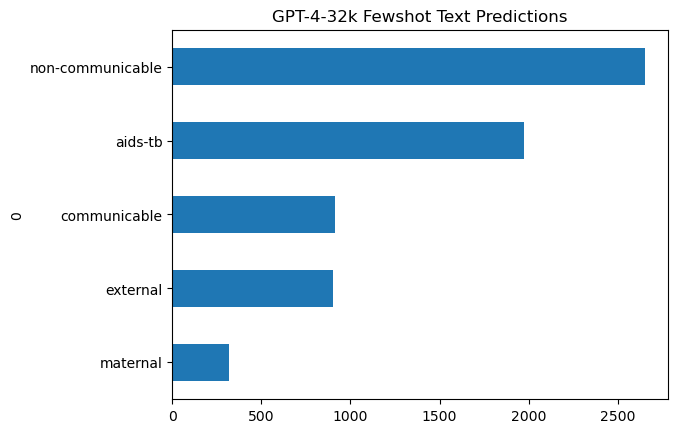

In [19]:
# plot text score dist
pd.Series(fewshot_predictions['0']).value_counts().plot.barh(title='GPT-4-32k Fewshot Text Predictions').invert_yaxis()

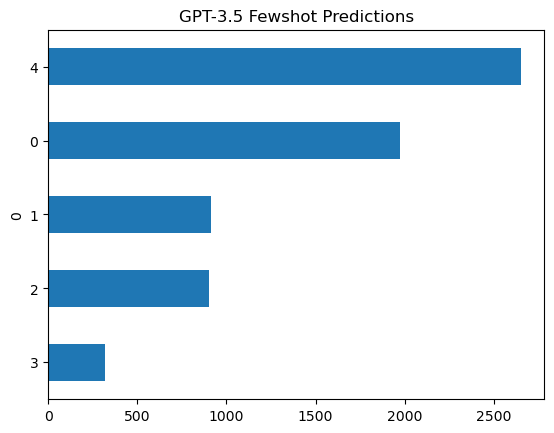

In [21]:
# plot text score dist
pd.Series(fewshot_scores['0']).value_counts().plot.barh(title='GPT-3.5 Fewshot Predictions').invert_yaxis()

## Compute and Compare Accuracy

In [118]:
predictions_classic = pd.read_csv('../classic_nlp/baseline_predictions.csv')
# predictions_bert = pd.read_csv('../transformer_nlp/predictions_bert.csv')
predictions_gtp35_zeroshot = pd.read_csv('gpt35_zeroshot_score.csv')
predictions_gtp35_fewshot = pd.read_csv('gpt35_fewshot_score.csv')
predictions_gpt432k_zeroshot = pd.read_csv('gpt4-32k_zeroshot_score.csv')
predictions_gpt432k_fewshot = pd.read_csv('gpt-4-32k_fewshot_score.csv')

In [119]:
accuracy_df = predictions_classic.copy()
# accuracy_df['predictions_BERT'] = predictions_bert
accuracy_df['predictions_GPT35_zeroshot'] = predictions_gtp35_zeroshot
accuracy_df['predictions_GPT35_fewshot'] = predictions_gtp35_fewshot
accuracy_df['predictions_GPT4-32k_zeroshot'] = predictions_gpt432k_zeroshot
accuracy_df['predictions_GPT4-32k_fewshot'] = predictions_gpt432k_fewshot


accuracy_df = accuracy_df.rename(columns={"predictions_NB": "NB", 
                            "predictions_SVM": "SVM", 
                            "predictions_KNN": "KNN",
#                             "predictions_BERT": "BERT",
                            "predictions_GPT35_zeroshot": "GPT35_zeroshot",
                            "predictions_GPT35_fewshot": "GPT35_fewshot",
                            "predictions_GPT4-32k_zeroshot": "GPT4-32k_zeroshot",
                            "predictions_GPT4-32k_fewshot": "GPT4-32k_fewshot"})

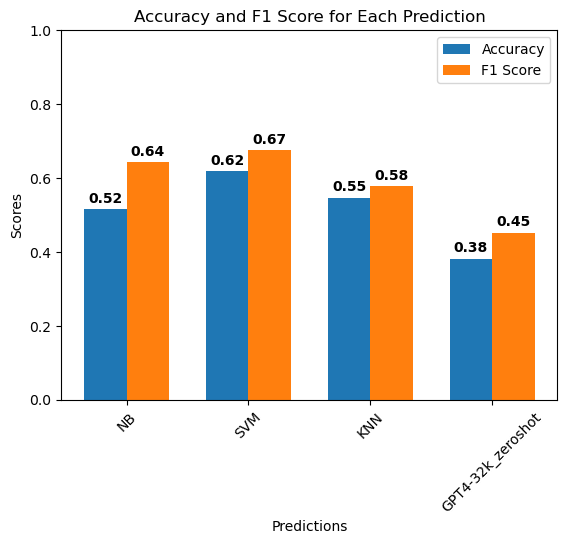

In [120]:
# Calculate accuracy and F1 score for each prediction column
columns_to_evaluate = ['NB', 'SVM', 'KNN', 'GPT4-32k_zeroshot']
accuracy_scores = []
f1_scores = []

for column in columns_to_evaluate:
    accuracy = accuracy_score(accuracy_df[column], accuracy_df['Test_Y'])
    f1 = f1_score(accuracy_df[column], accuracy_df['Test_Y'] , average = 'weighted')
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

# Plot the results
fig, ax = plt.subplots()

bar_width = 0.35
index = np.arange(len(columns_to_evaluate))

bar1 = ax.bar(index, accuracy_scores, bar_width, label='Accuracy')
bar2 = ax.bar(index + bar_width, f1_scores, bar_width, label='F1 Score')

ax.set_xlabel('Predictions')
ax.set_ylabel('Scores')
ax.set_title('Accuracy and F1 Score for Each Prediction')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(columns_to_evaluate)
plt.xticks(rotation=45)
ax.legend()
# Set y-axis range to 0-1
ax.set_ylim(0, 1)

# Add scores on top of each bar
for i, (acc, f1) in enumerate(zip(accuracy_scores, f1_scores)):
    ax.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom', color='black', fontweight='bold')
    ax.text(i + bar_width, f1 + 0.01, f'{f1:.2f}', ha='center', va='bottom', color='black', fontweight='bold')

plt.show()